# GENERATING A SYNTHETIC GRAPH

## Preliminaries

In [103]:
pip install torch

You should consider upgrading via the 'C:\Users\noure\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [63]:
#Libraries
import networkx as nx 
import random           # for randomly assigning edge directions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Goods-Flow Directed Graph (BA)

In [20]:
def generate_goods_flow_graph(n,m):
    """ 
    Description:
        Creates a directed graph that has been generated using the BA model. Nodes represent companies, and links represent an exchange of 
        goods from one to another.

    Args:
        n = total number of nodes of the graph
        m = number of nodes to which a node attaches when introduced to the network.

    Returns:
        G = the original BA undirected graph
        DG = the undirected graph
    
    """
    G = nx.barabasi_albert_graph(n,m)            # undirected BA graph
    G.remove_edges_from(nx.selfloop_edges(G))
    G.remove_nodes_from(list(nx.isolates(G)))
    DG = nx.DiGraph()                            # empty directed graph
    DG.add_nodes_from(G.nodes())           # add nodes in G
    # build directed graph (one link per pair)
    for u,v in list(G.edges()):
        if random.random() < 0.5:                # random returns a random number between 0 and 1
            DG.add_edge(u,v, edge_type= 'goods') # edge: u --> v
        else:
            DG.add_edge(v,u, edge_type= 'goods') # edge:v--> u
    
    return G, DG

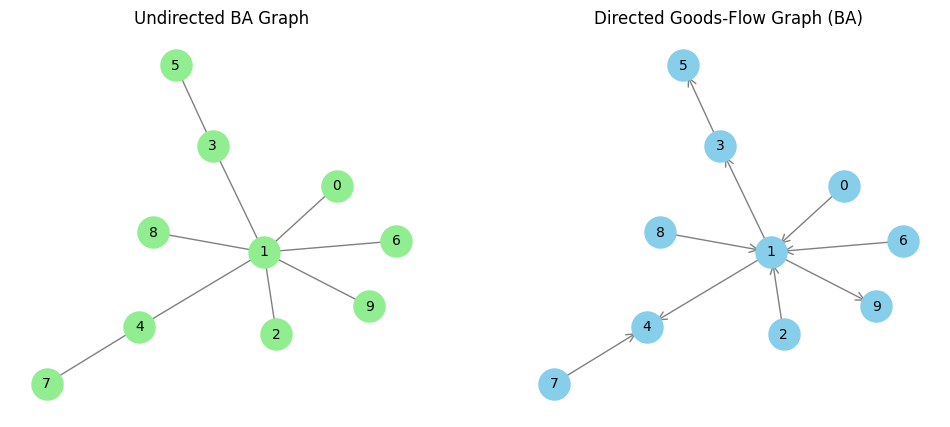

In [38]:
BA_graph, goodsFlow = generate_goods_flow_graph(10, 1)

pos = nx.spring_layout(BA_graph, seed=42)

# --- Plot undirected BA graph ---
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(BA_graph, pos, node_size=500, node_color='lightgreen')
nx.draw_networkx_edges(BA_graph, pos, edge_color='gray')
nx.draw_networkx_labels(BA_graph, pos, font_size=10)
plt.title("Undirected BA Graph")
plt.axis('off')

# --- Plot directed goods-flow graph ---
plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(goodsFlow, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(goodsFlow, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_labels(goodsFlow, pos, font_size=10)
plt.title("Directed Goods-Flow Graph (BA)")
plt.axis('off')

plt.show()

## Graph With Goods-Flow and Repayment-Flow

In [36]:
def add_repayment_edges(G, p):
    """
    Adds repayment edges to our directed goods-flow graph.

    Args:
        G (nx.DiGraph): directed goods-flow graph
        p (float): probability of adding a repayment edge for each goods edge

    Returns:
        nx.DiGraph: graph with repayment edges added
    """
    DG = G.copy() # copy original graph
    for u,v in list(G.edges):
        if random.random() < p:
            DG.add_edge(v,u, edge_type = 'repayment')
    return DG

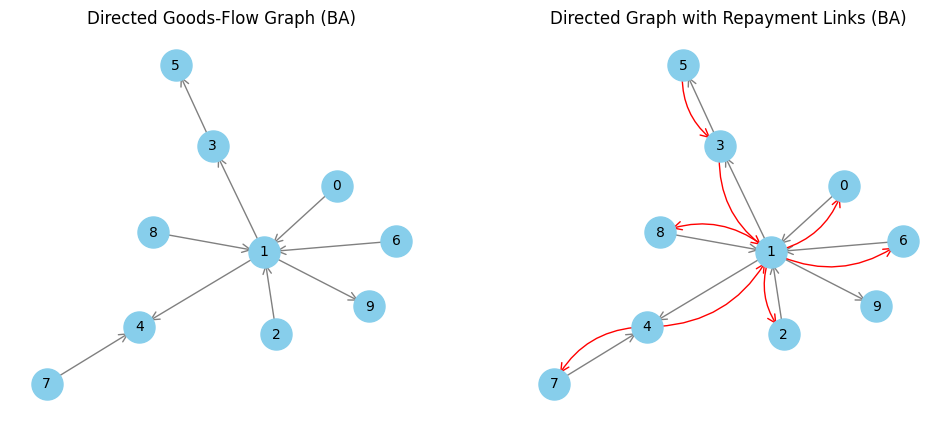

In [40]:
FullyLinked = add_repayment_edges(goodsFlow, p=0.95)

pos = nx.spring_layout(BA_graph, seed=42)
plt.figure(figsize=(12,5))

# --- Plot directed goods-flow graph ---
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(goodsFlow, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(goodsFlow, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_labels(goodsFlow, pos, font_size=10)
plt.title("Directed Goods-Flow Graph (BA)")
plt.axis('off')

plt.subplot(1, 2, 2)

# --- Plot directed fully-linked graph ---

# Filter edges by type
goods_edges = []  # start with empty list

for edge in FullyLinked.edges(data=True):
    u = edge[0]       # source node
    v = edge[1]       # target node
    d = edge[2]       # attributes dictionary
    
    if d['edge_type'] == 'goods':  # filter for goods edges
        goods_edges.append((u, v))  # add tuple (u,v) to list

repayment_edges = []  # start with empty list

for edge in FullyLinked.edges(data=True):
    u = edge[0]       # source node
    v = edge[1]       # target node
    d = edge[2]       # attributes dictionary
    
    if d['edge_type'] == 'repayment':  # filter for goods edges
        repayment_edges.append((u, v))  # add tuple (u,v) to list

nx.draw_networkx_nodes(FullyLinked, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(FullyLinked, pos, edgelist=goods_edges, edge_color='gray', arrowstyle='->', arrowsize=15)
nx.draw_networkx_edges(FullyLinked, pos, edgelist=repayment_edges, edge_color='red', arrowstyle='->', arrowsize=15, connectionstyle='arc3, rad=0.3' )
nx.draw_networkx_labels(FullyLinked, pos, font_size=10)
plt.title("Directed Graph with Repayment Links (BA)")
plt.axis('off')

plt.show()

## Adding Node and Edge Features

#### Node features

In [79]:
def add_node_features(G, seed = 42):
    """
    Description:
        For each node in the graph, it assigns its attributes randomly from probability distributions.
    Args:
        Graph
    Return:
        Graph with node attributes
    """
    TD = G.copy()
    np.random.seed(seed=40)
    
    for node in TD.nodes():
        # Cash flow: log-normal
        TD.nodes[node]['cash_flow'] = np.random.lognormal(mean=12, sigma=1)
        
        # Debt/Capital ratio: log-normal
        TD.nodes[node]['debt_to_capital'] = np.random.lognormal(mean=-1.1, sigma=0.6)
        
        # Historical unpaid transactions (fraction between 0 and 1)
        TD.nodes[node]['unpaid_fraction'] = np.random.uniform(0, 1)
        
        # Age of company: normal with mean 18, sigma=5, clipped at 1+
        age = int(np.random.normal(loc=18, scale=5))
        TD.nodes[node]['age'] = max(age, 1)  # ensure age ≥ 1

    return TD
    

In [90]:
DGN = add_node_features(FullyLinked)
print(DGN.nodes[0])

df = pd.DataFrame.from_dict(dict(DGN.nodes(data=True)), orient='index')
means = df.mean()
minimum = df.min()
maximum = df.max()
sdv = df.std()
print("MEANS----------------------")
print(means)
print("MINIMUM--------------------")
print(minimum)
print("MAXIMUM--------------------")
print(maximum)
print("SPREAD---------------------")
print(sdv)


{'cash_flow': 88650.0878775847, 'debt_to_capital': 0.30860848361986193, 'unpaid_fraction': 0.7885348774867527, 'age': 15}
MEANS----------------------
cash_flow          213014.724540
debt_to_capital         0.476460
unpaid_fraction         0.510252
age                    16.800000
dtype: float64
MINIMUM--------------------
cash_flow          27653.767578
debt_to_capital        0.238810
unpaid_fraction        0.036655
age                    8.000000
dtype: float64
MAXIMUM--------------------
cash_flow          767335.368136
debt_to_capital         1.334799
unpaid_fraction         0.980939
age                    27.000000
dtype: float64
SPREAD---------------------
cash_flow          218890.540074
debt_to_capital         0.321871
unpaid_fraction         0.345117
age                     6.646637
dtype: float64


#### Edge features

In [96]:
def add_edge_features(G, seed = 42):
    """
    Description:
    Adds features to the edges of the graph G.
    
    Features:
    - If edge_type = "goods":
        * invoice_amount: log-normal
        * days_until_due: uniform [1, 90]
        * interest_rate: uniform [0.03, 0.10]
    - If edge_type = "repayment":
        * repayment_amount: uniform [0.5*invoice_amount, invoice_amount] --> at least the insurance company covers half of the transaction amount
        * days_overdue: uniform [0, 90]
    Args: Graph
    Return: graph
    """
    TD = G.copy()
    np.random.seed(seed)
    for u, v, data in TD.edges(data=True):
        edge_type = data.get('edge_type', 'unknown')
        
        if edge_type == 'goods':
            # Invoice amount: log-normal (skewed, positive)
            try:
                if data['invoice_amount'] == None:
                    data['invoice_amount'] = np.random.lognormal(mean=10, sigma=1)
            except:
                data['invoice_amount'] = np.random.lognormal(mean=10, sigma=1)
            
            # Days until due: uniform [1, 90]
            data['days_until_due'] = np.random.uniform(1, 90)
            
            # Interest rate: uniform [0.03, 0.10]
            data['interest_rate'] = np.random.uniform(0.03, 0.10)
            
        else:
            invoice = None
            if TD.has_edge(v, u):
                goods_data = TD[v][u]
                if goods_data.get('edge_type') == 'goods':
                    invoice = goods_data.get('invoice_amount', None)
            if invoice is None: # in case we still haven't filled the goods edge
                invoice = np.random.lognormal(mean=10, sigma=1)
            data['repayment_amount'] = np.random.uniform(0.5*invoice, invoice)
            
            # Days overdue: uniform [0, 90]
            data['days_overdue'] = np.random.uniform(0, 90)
        
    
    return TD
    

In [102]:
TD = add_edge_features(DGN)
edge = list(TD.edges(data=True))[0]
print(edge)

edge_dict = {}
for u, v, attr in TD.edges(data=True):
    edge_dict[(u, v)] = attr

df = pd.DataFrame.from_dict(edge_dict, orient='index')
numeric_df = df.select_dtypes(include='number')
means = numeric_df.mean()
minimum = numeric_df.min()
maximum = numeric_df.max()
sdv = numeric_df.std()
print("MEANS----------------------")
print(means)
print("MINIMUM--------------------")
print(minimum)
print("MAXIMUM--------------------")
print(maximum)
print("SPREAD---------------------")
print(sdv)

(0, 1, {'edge_type': 'goods', 'invoice_amount': 36196.371320026, 'days_until_due': 66.14746082121505, 'interest_rate': 0.07190609389379257})
MEANS----------------------
invoice_amount      31594.398340
days_until_due         34.504912
interest_rate           0.064054
repayment_amount    24076.472033
days_overdue           41.562123
dtype: float64
MINIMUM--------------------
invoice_amount      5365.239518
days_until_due         2.832020
interest_rate          0.040920
repayment_amount    2620.071688
days_overdue           8.790490
dtype: float64
MAXIMUM--------------------
invoice_amount      106853.371679
days_until_due          75.087395
interest_rate            0.097894
repayment_amount    105017.205107
days_overdue            85.399698
dtype: float64
SPREAD---------------------
invoice_amount      31271.027525
days_until_due         27.324351
interest_rate           0.022575
repayment_amount    33335.455276
days_overdue           30.529801
dtype: float64


## Saving the Graph